In [7]:
# core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import json
import time

#torch
import torch
import torch.nn as nn
import torch.optim as optim

# images
from PIL import Image
from IPython.display import display

# custom
from scripts.preprocess import preprocess_resnet
from scripts.train_resnet import train_model, load_data

# Load Data

In [2]:
%run scripts/get_data.py

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
Number of train files: 14034
Number of test files: 3000
Number of pred files: 7301
Creating validation folder and moving random train images to validation...
Folders in data/val: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# EDA

#### View Images

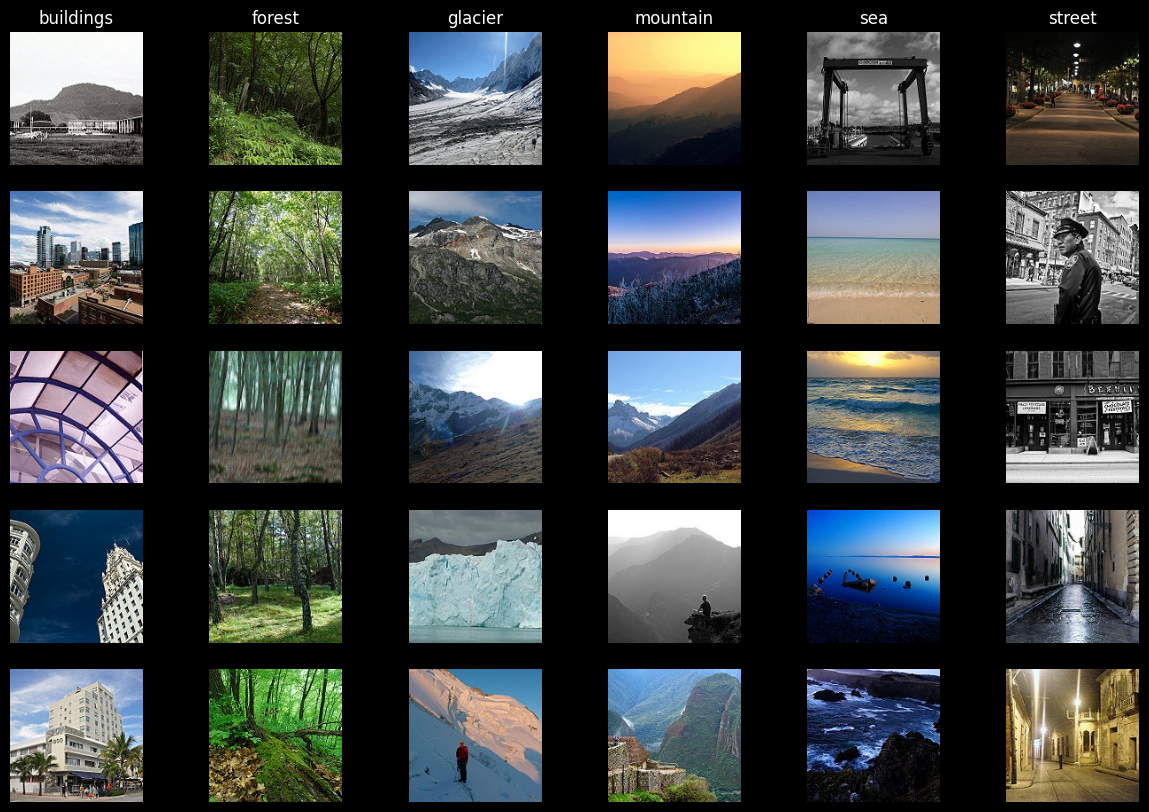

In [25]:
fig, axes = plt.subplots(5, 6, figsize=(15, 10))

for col, label in enumerate(os.listdir('data/train')):
    for row in range(5):
        img_filename = os.listdir(f'data/train/{label}')[row]
        img_path = os.path.join(f'data/train/{label}', img_filename)
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if row % 5 == 0:
            axes[row, col].set_title(label)

plt.show()

#### Distribution Across Classes

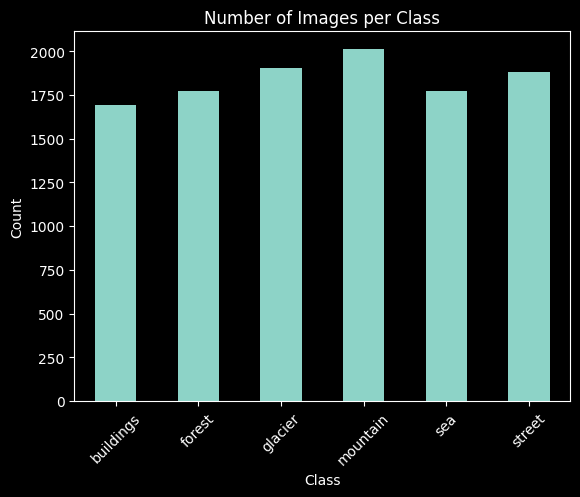

In [4]:
class_counts = {}
for folder in os.listdir('data/train'):
    class_path = f'data/train/{folder}'
    if os.path.isdir(class_path):
        class_counts[folder] = len(os.listdir(class_path))

pd.DataFrame(class_counts, index=['count']).transpose().plot(kind='bar')
plt.title('Number of Images per Class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.legend().remove()
plt.show()

#### Distribution of Image Sizes

In [5]:
sizes = []
for folder in os.listdir('data/train'):
    class_path = f'data/train/{folder}'
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            sizes.append(img.size)

sizes = np.array(sizes)
width_vals, width_cts = np.unique(sizes[:, 0], return_counts=True)
height_vals, height_cts = np.unique(sizes[:, 1], return_counts=True)

print(
    f'Widths: {width_vals}'
    f'\nCounts: {width_cts}'
    f'\n\nHeights: {height_vals}' 
    f'\nCounts: {height_cts}'
)

Widths: [150]
Counts: [11034]

Heights: [ 76  81  97 100 102 103 105 108 111 113 115 119 120 123 131 134 135 136
 141 142 143 144 145 146 147 149 150]
Counts: [    1     1     1     1     1     1     1     2     3     7     1     1
     1     2     1     2     3     1     1     2     2     2     1     1
     1     1 10992]


#### Pixel Intensity Distribution

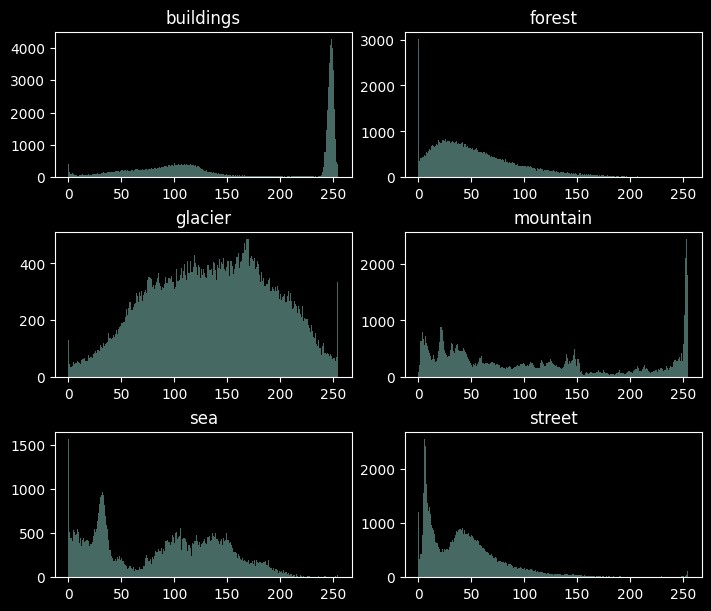

In [6]:
# For a single, random image in each class
fig, axes = plt.subplots(3, 2, figsize=(7,6), layout='constrained')
for folder, ax in zip(os.listdir('data/train'), axes.ravel()):
    class_path = f'data/train/{folder}'
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            ax.hist(img_array.ravel(), bins=256, alpha=0.5, label=f'{folder} (sample)')
            break
    ax.set_title(folder)

plt.show()

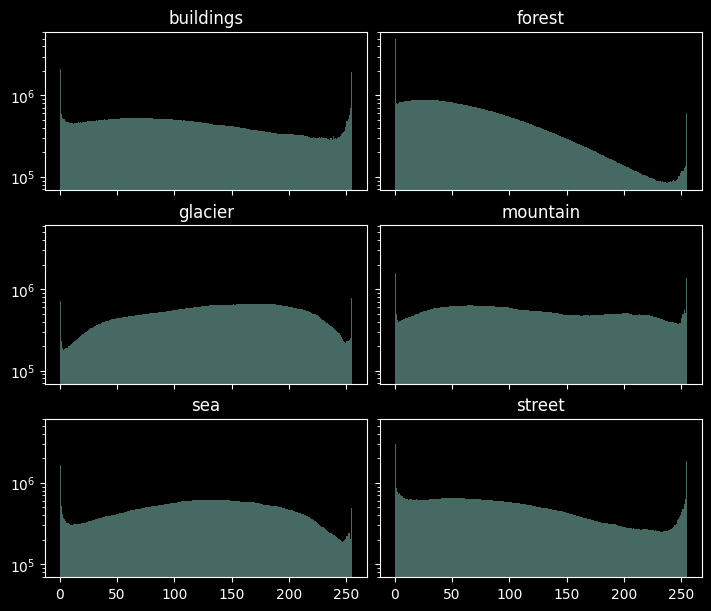

In [7]:
# Aggregated across all images
fig, axes = plt.subplots(3, 2, figsize=(7, 6), layout='constrained', sharex=True, sharey=True)

# Iterate over each class folder
for folder, ax in zip(os.listdir('data/train'), axes.ravel()):
    class_path = f'data/train/{folder}'
    total_hist = np.zeros(256)  # Initialize a histogram to accumulate pixel values

    # Accumulate histogram data from all images in the class folder
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            img_array = np.array(img)
            hist, _ = np.histogram(img_array.ravel(), bins=256, range=[0, 256])
            total_hist += hist  # Accumulate the histograms

    # Plot the accumulated histogram
    ax.hist(np.arange(256), weights=total_hist, bins=256, alpha=0.5, label=f'{folder} (aggregate)')
    ax.set_title(folder)
    ax.legend().remove()
    ax.set_yscale('log')

plt.show()

#### Distribution Across RGB Color Channels

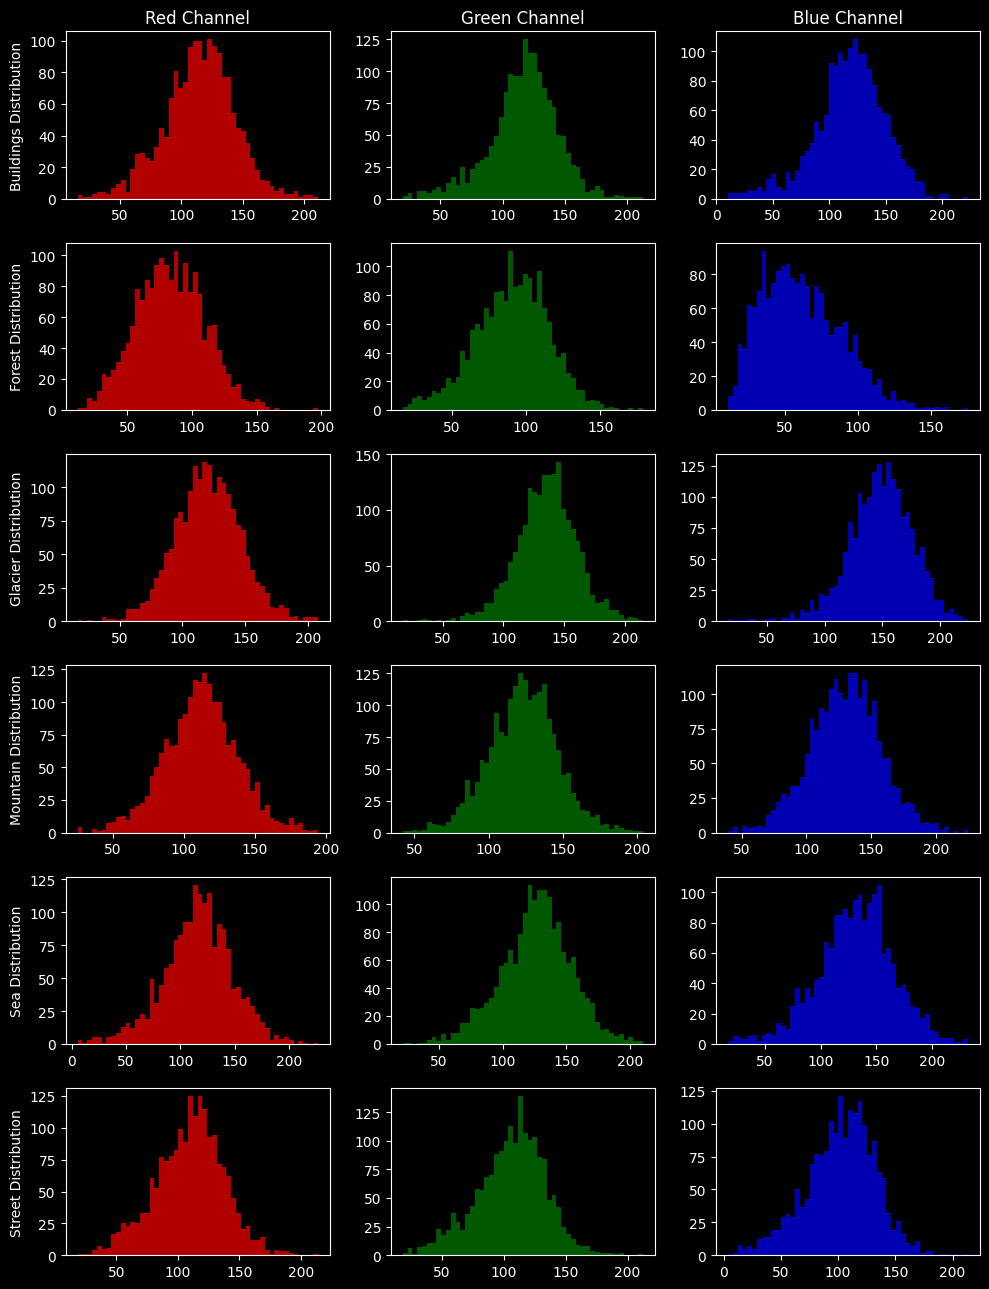

In [8]:
# Set up the plot
fig, axes = plt.subplots(6, 3, figsize=(10, 13), layout='tight')

# Set titles for columns
axes[0, 0].set_title('Red Channel')
axes[0, 1].set_title('Green Channel')
axes[0, 2].set_title('Blue Channel')

# Iterate over each class directory
for folder, ax_row in zip(os.listdir('data/train'), axes):
    class_path = f'data/train/{folder}'
    colors = []

    # Collect all colors in this class
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        with Image.open(image_path) as img:
            colors.append(np.mean(np.array(img), axis=(0, 1)))
    colors = np.array(colors)

    # Plot histograms for each color channel
    ax_row[0].hist(colors[:, 0], bins=50, color='red', alpha=0.7)
    ax_row[1].hist(colors[:, 1], bins=50, color='green', alpha=0.7)
    ax_row[2].hist(colors[:, 2], bins=50, color='blue', alpha=0.7)

    # Set class label as the row title
    ax_row[0].set_ylabel(f'{folder.title()} Distribution')

plt.tight_layout()
plt.show()

#### Check for Corrupt Images

In [9]:
bad_files = []
for folder in os.listdir('data/train'):
    class_path = f'data/train/{folder}'
    for i, image_name in enumerate(os.listdir(class_path)):
        try:
            image_path = os.path.join(class_path, image_name)
            with Image.open(image_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print('Bad file:', image_name)
            bad_files.append(f'{folder}/{image_name}')

print(f'Number of bad files: {len(bad_files)}')

Number of bad files: 0


# Preprocessing

#### Carve Out Validation Subset, then Proprocess for ResNet and XGBoost

In [4]:
%run scripts/preprocess.py

Number of train files: 11034
Number of val files: 3000
Number of test files: 3000

Preprocessing images for ResNet50...
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}

Creating flat, tabular dataset for XGBoost...
Train features shape: (11034, 150528)
Train labels shape: (11034,)
Val features shape: (3000, 150528)
Val labels shape: (3000,)
Test features shape: (3000, 150528)
Test labels shape: (3000,)

Time elapsed: 0.76 minutes


# Benchmark XGBoost Training

In [1]:
%run scripts/train_benchmark.py

Performing PCA with 5517 components...

PCA Complete - Time elapsed: 3.77 minutes
Train PCA shape: (11034, 5517)
Val PCA shape: (3000, 5517)

              precision    recall  f1-score   support

   buildings       0.59      0.35      0.44       500
      forest       0.81      0.80      0.80       500
     glacier       0.53      0.60      0.56       500
    mountain       0.49      0.68      0.57       500
         sea       0.54      0.40      0.46       500
      street       0.60      0.71      0.65       500

    accuracy                           0.59      3000
   macro avg       0.60      0.59      0.58      3000
weighted avg       0.60      0.59      0.58      3000

Time elapsed: 5.46 minutes


# ResNet-50 Setup and Baseline Training

Data Loaded...
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}

Epoch 1/169 - Time Elapsed: 0.00 minutes
----------
Train Loss: 0.8942 - Accuracy: 0.7471
Val Loss: 0.4596 - Accuracy: 0.8813

Epoch 17/169 - Time Elapsed: 8.68 minutes
----------
Train Loss: 0.3949 - Accuracy: 0.8549
Val Loss: 0.2495 - Accuracy: 0.9080

Epoch 33/169 - Time Elapsed: 16.51 minutes
----------
Train Loss: 0.3737 - Accuracy: 0.8641
Val Loss: 0.2359 - Accuracy: 0.9087

Epoch 49/169 - Time Elapsed: 24.23 minutes
----------
Train Loss: 0.3827 - Accuracy: 0.8604
Val Loss: 0.2322 - Accuracy: 0.9140

Epoch 65/169 - Time Elapsed: 31.96 minutes
----------
Train Loss: 0.3707 - Accuracy: 0.8586
Val Loss: 0.2310 - Accuracy: 0.9130

Epoch 81/169 - Time Elapsed: 39.68 minutes
----------
Train Loss: 0.3560 - Accuracy: 0.8675
Val Loss: 0.2258 - Accuracy: 0.9163

Epoch 97/169 - Time Elapsed: 47.41 minutes
----------
Train Loss: 0.3539 - Ac

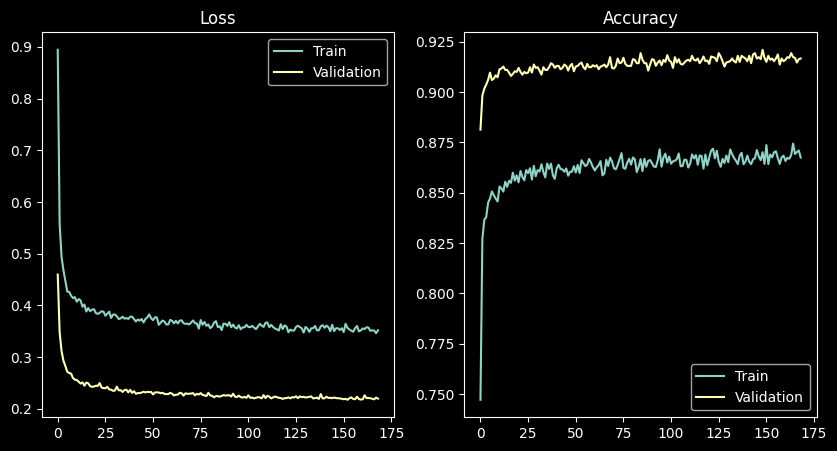

<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
%run scripts/train_resnet.py

# Error Analysis

#### Classification Report - Training Data


Classification Report -- Train

              precision    recall  f1-score   support

   buildings       0.88      0.90      0.89      1691
      forest       0.98      0.98      0.98      1771
     glacier       0.87      0.79      0.83      1904
    mountain       0.82      0.85      0.83      2012
         sea       0.89      0.93      0.91      1774
      street       0.91      0.88      0.89      1882

    accuracy                           0.89     11034
   macro avg       0.89      0.89      0.89     11034
weighted avg       0.89      0.89      0.89     11034


Classification Report -- Validation

              precision    recall  f1-score   support

   buildings       0.94      0.92      0.93       500
      forest       0.99      0.99      0.99       500
     glacier       0.91      0.83      0.87       500
    mountain       0.85      0.90      0.88       500
         sea       0.95      0.98      0.97       500
      street       0.92      0.94      0.93       500

    ac

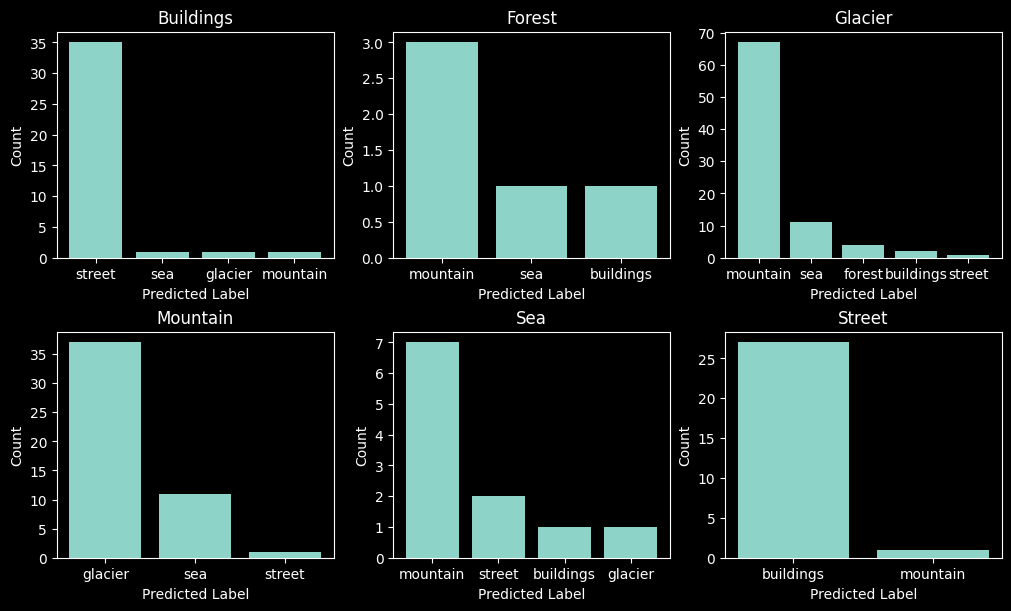

<Figure size 640x480 with 0 Axes>

In [1]:
%matplotlib inline
%run scripts/error_analysis.py

# Optimize num_workers

Processing with 0 workers...
Time to complete: 4.38 min
Processing with 1 workers...
Time to complete: 3.53 min
Processing with 2 workers...
Time to complete: 3.66 min
Processing with 4 workers...
Time to complete: 5.17 min
Processing with 8 workers...
Time to complete: 7.95 min


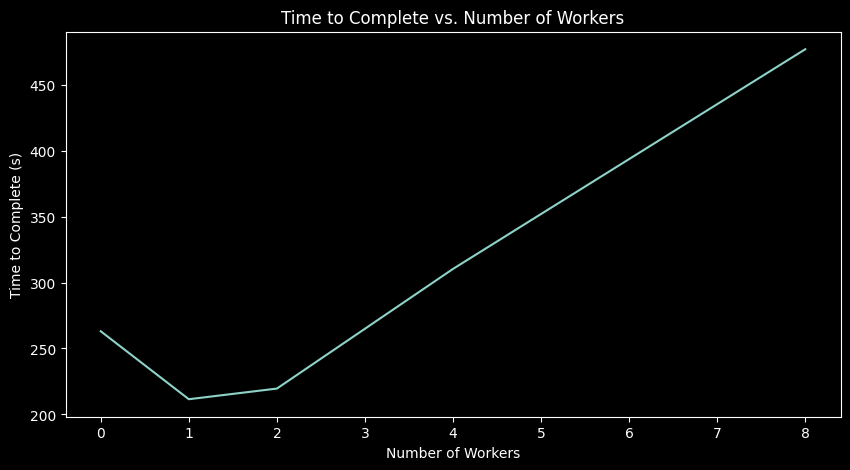

In [3]:
with open('scripts/config.json', 'r') as f:
    config = json.load(f)

time_to_complete = {}
avg_gpu_util = {}

for num_workers in [0, 1, 2, 4, 8]:
    print(f'Processing with {num_workers} workers...')
    start = time.time()
    image_datasets, dataloaders, dataset_sizes, class_names = preprocess_resnet(batch_size=32, num_workers=num_workers)
    results = train_model(
        dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names,
        learning_rate=config['learning_rate'], dropout=config['dropout'],
        optimizer_class={'Adam': optim.Adam, 'SGD': optim.SGD}[config['optimizer']],
        num_epochs=10, print_progress=False, save_model=False
    )
    time_to_complete[num_workers] = time.time() - start
    # avg_gpu_util[num_workers] = np.mean(results['gpu_util'])
    print(f'Time to complete: {time_to_complete[num_workers] / 60:.2f} min')

plt.figure(figsize=(10, 5))
plt.plot(list(time_to_complete.keys()), list(time_to_complete.values()))
plt.xlabel('Number of Workers')
plt.ylabel('Time to Complete (s)')
plt.title('Time to Complete vs. Number of Workers')
plt.show()

# Hyperparameter Tuning

In [1]:
%run scripts/tune_hps.py

[I 2025-02-18 19:48:40,784] A new study created in memory with name: no-name-7a9ae65e-50a5-48a7-9ccf-d13008e44a74
[I 2025-02-18 21:18:50,131] Trial 0 finished with value: 0.8836666666666666 and parameters: {'batch_size': 13, 'random_horizontal_flip': True, 'random_rotation': False, 'random_color_jitter': True, 'learning_rate': 0.0012790325963103117, 'dropout': 0.2222772622172159, 'optimizer': 'Adam', 'num_epochs': 128}. Best is trial 0 with value: 0.8836666666666666.
[I 2025-02-18 22:03:42,819] Trial 1 finished with value: 0.9176666666666666 and parameters: {'batch_size': 43, 'random_horizontal_flip': True, 'random_rotation': False, 'random_color_jitter': False, 'learning_rate': 0.007311684142361743, 'dropout': 0.23189298325991833, 'optimizer': 'SGD', 'num_epochs': 124}. Best is trial 1 with value: 0.9176666666666666.
[I 2025-02-18 22:47:06,762] Trial 2 finished with value: 0.9026666666666666 and parameters: {'batch_size': 50, 'random_horizontal_flip': False, 'random_rotation': True, '

In [3]:
hp_results = pd.read_csv('logs/tuning-20250219-1953.csv', index_col=0)
hp_results.sort_values('value', ascending=False).head(3).T

,28,27,1
number,28,27,1
value,0.920667,0.919333,0.917667
datetime_start,2025-02-19 17:39:20.319485,2025-02-19 17:00:01.080219,2025-02-18 21:18:50.131898
datetime_complete,2025-02-19 18:23:44.729096,2025-02-19 17:39:20.304485,2025-02-18 22:03:42.803890
duration,0 days 00:44:24.409611,0 days 00:39:19.224266,0 days 00:44:52.671992
params_batch_size,21,18,43
params_dropout,0.198204,0.311292,0.231893
params_learning_rate,0.005245,0.00529,0.007312
params_num_epochs,119,105,124
params_optimizer,SGD,SGD,SGD


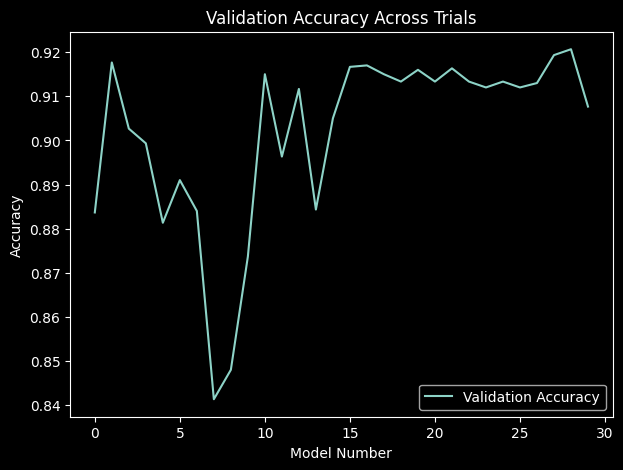

In [45]:
plt.figure(figsize=(7, 5))
plt.plot(hp_results['value'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Model Number')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Trials')
plt.show()

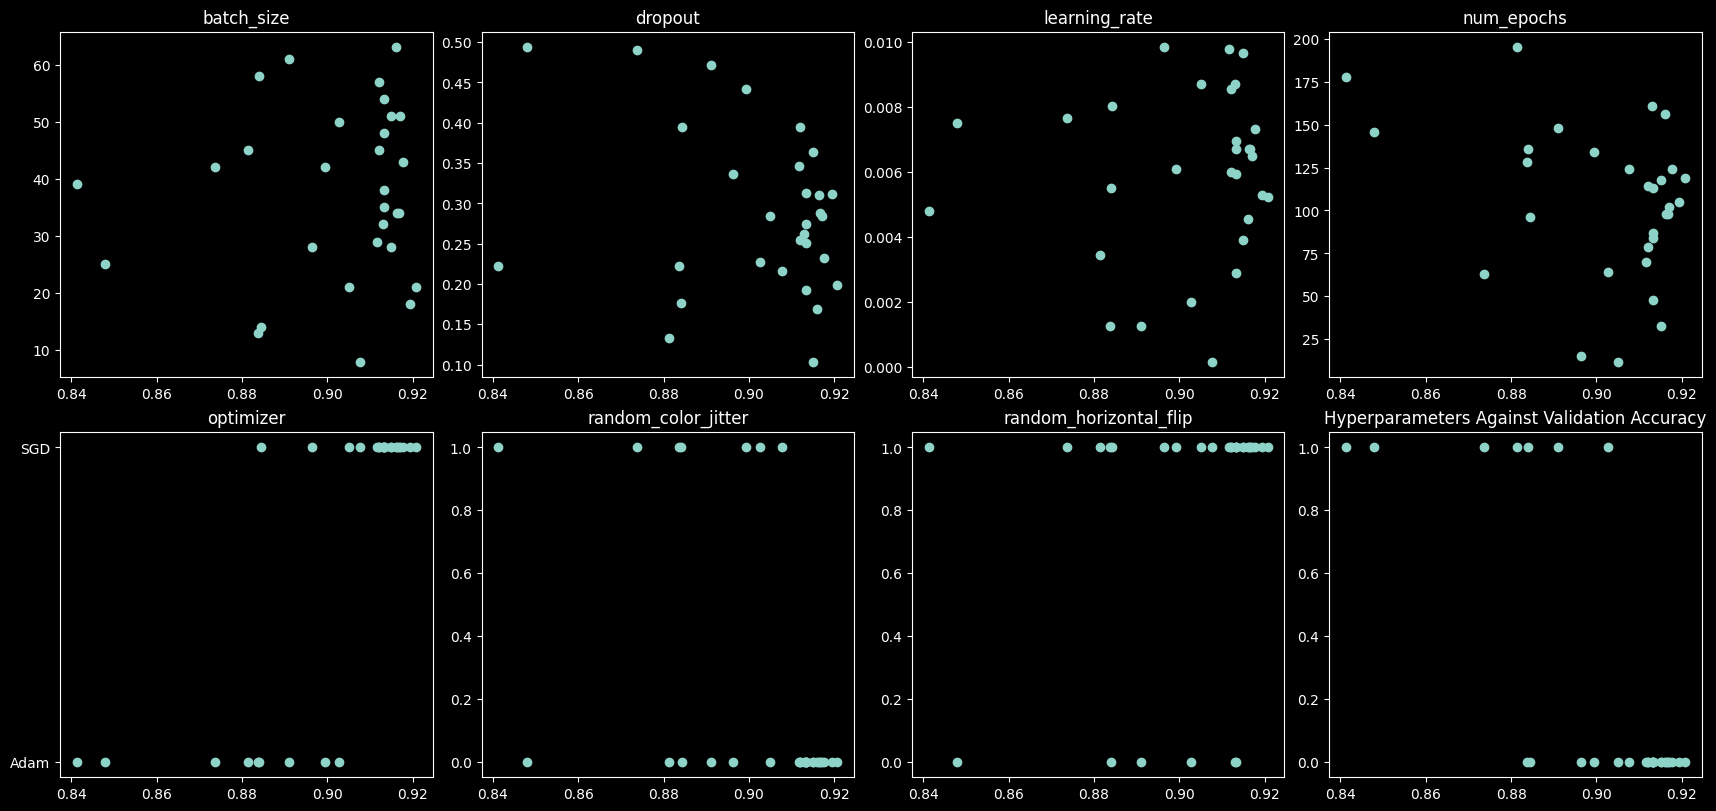

In [58]:
param_cols = [x for x in hp_results.columns if 'params_' in x]

fig, axes = plt.subplots(2, 4, figsize=(17, 8), layout='constrained')
for col, ax in zip(param_cols, axes.ravel()):
    ax.scatter(hp_results['value'], hp_results[col])
    ax.set_title(col.split('params_')[1])
plt.title('Hyperparameters Against Validation Accuracy')
plt.show()

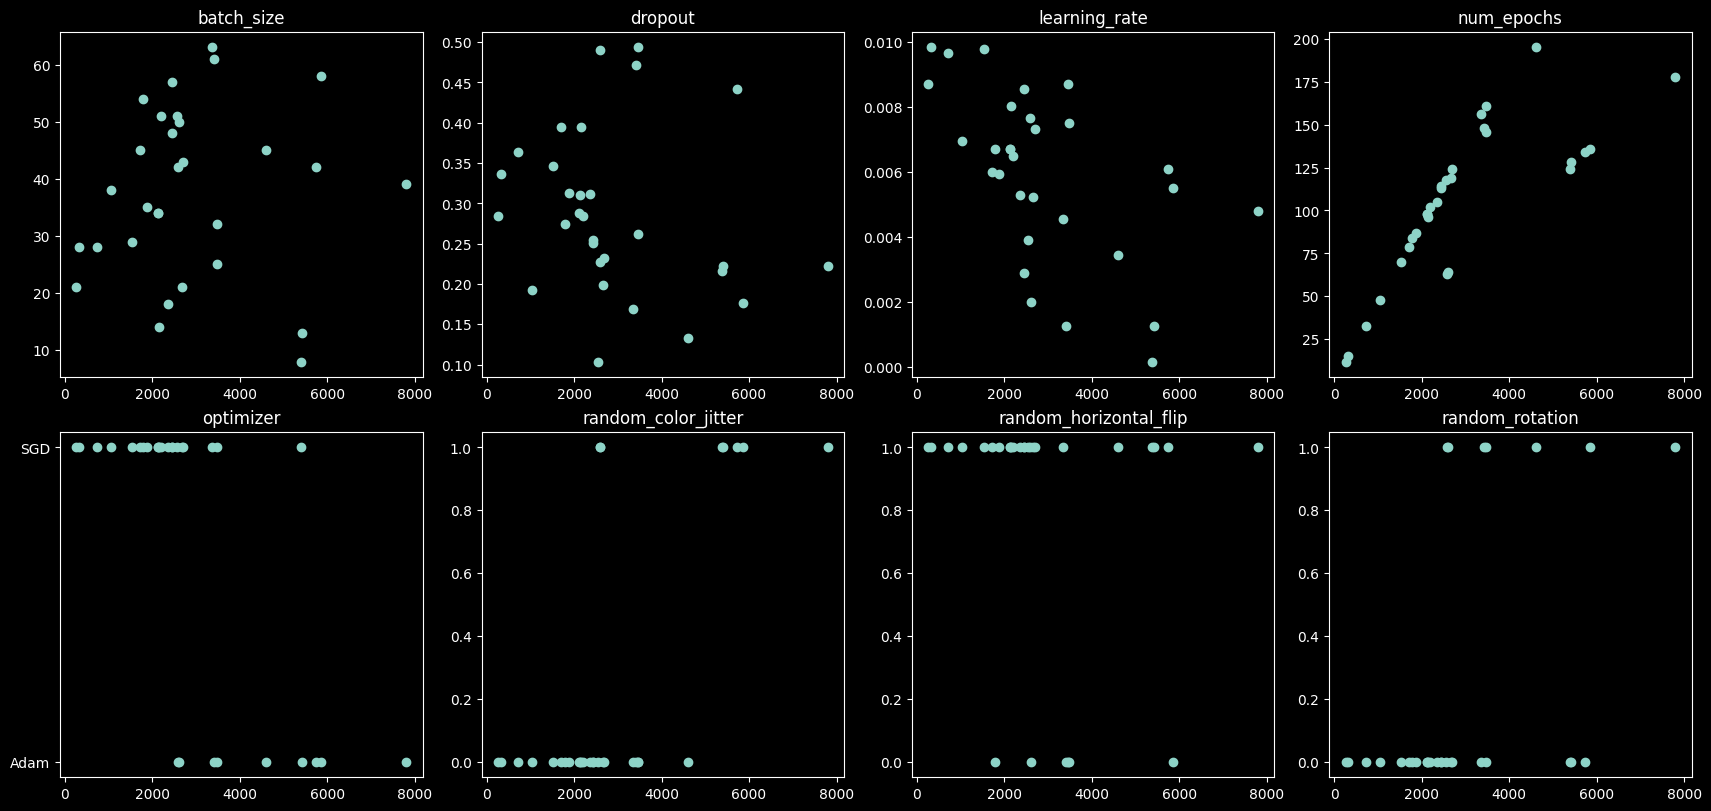

In [82]:
fig, axes = plt.subplots(2, 4, figsize=(17, 8), layout='constrained')
for col, ax in zip(param_cols, axes.ravel()):
    ax.scatter([x.total_seconds() for x in pd.to_timedelta(hp_results['duration'])], hp_results[col])
    ax.set_title(col.split('params_')[1])
plt.show()

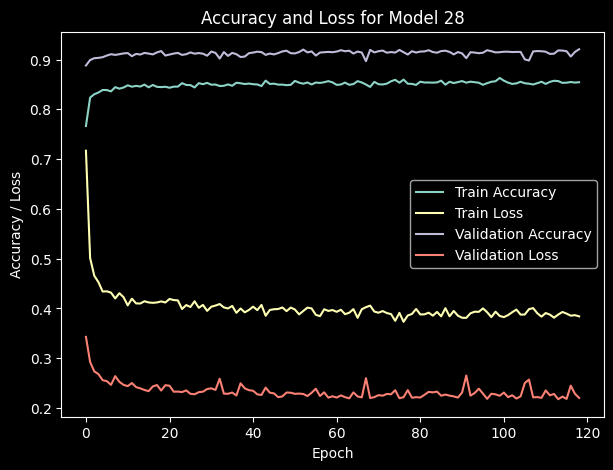

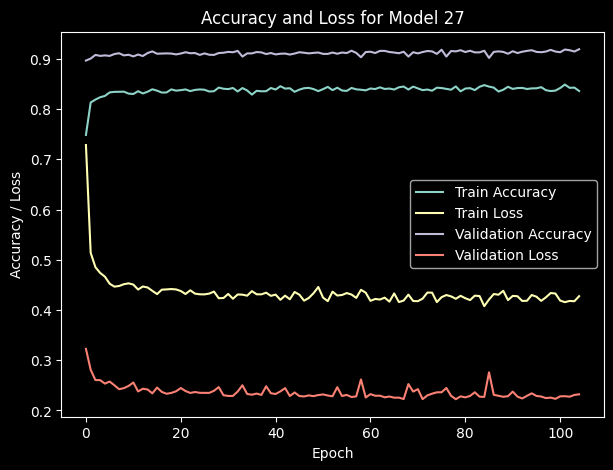

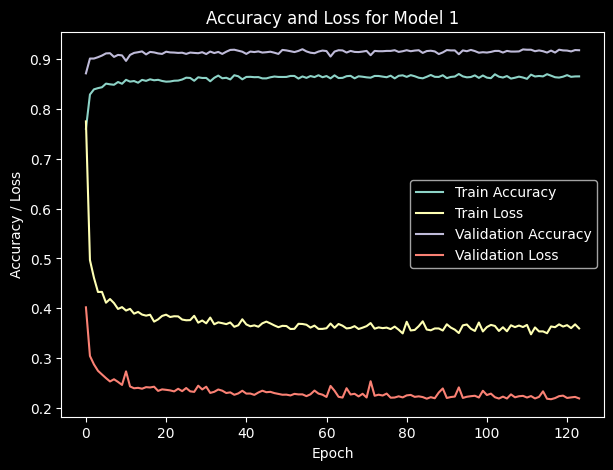

In [ ]:
top3 = hp_results.sort_values('value', ascending=False).head(3)['number'].tolist()

for idx in top3:
    train_accuracies = hp_results['user_attrs_train_accuracies'][idx]
    train_accuracies = re.findall(r'tensor\(([0-9.]+)', train_accuracies)
    train_accuracies = [float(x) for x in train_accuracies]

    val_accuracies = hp_results['user_attrs_val_accuracies'][idx]
    val_accuracies = re.findall(r'tensor\(([0-9.]+)', val_accuracies)
    val_accuracies = [float(x) for x in val_accuracies]

    train_losses = json.loads(hp_results['user_attrs_train_losses'][idx])
    val_losses = json.loads(hp_results['user_attrs_val_losses'][idx])

    plt.figure(figsize=(7, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    # plt.ylim(0, 1)
    plt.title(f'Accuracy and Loss for Model {idx}')
    plt.show()

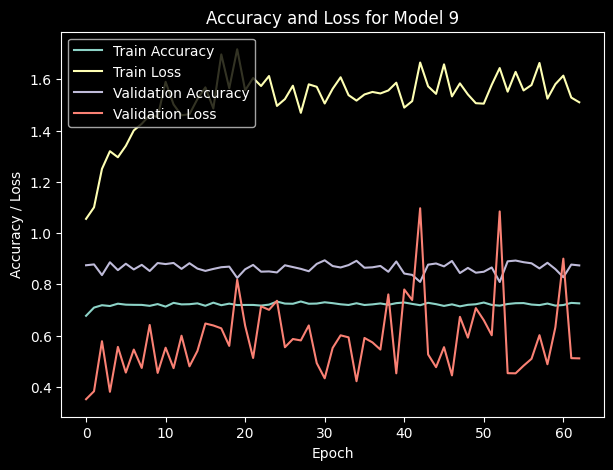

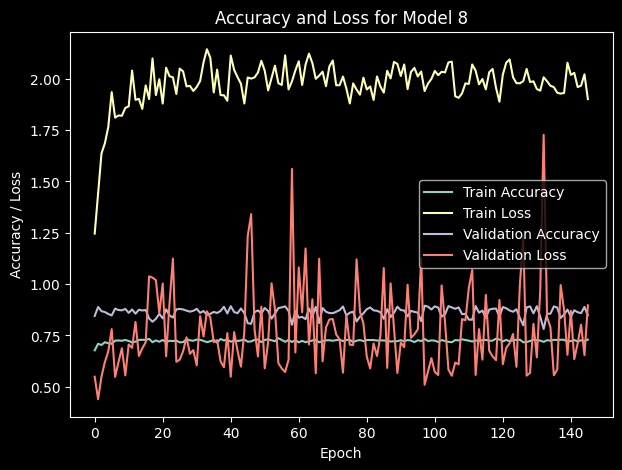

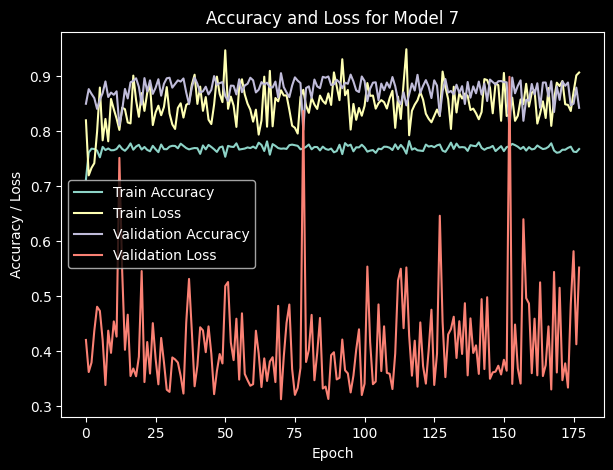

In [55]:
bottom3 = hp_results.sort_values('value', ascending=False).tail(3)['number'].tolist()

for idx in bottom3:
    train_accuracies = hp_results['user_attrs_train_accuracies'][idx]
    train_accuracies = re.findall(r'tensor\(([0-9.]+)', train_accuracies)
    train_accuracies = [float(x) for x in train_accuracies]

    val_accuracies = hp_results['user_attrs_val_accuracies'][idx]
    val_accuracies = re.findall(r'tensor\(([0-9.]+)', val_accuracies)
    val_accuracies = [float(x) for x in val_accuracies]

    train_losses = json.loads(hp_results['user_attrs_train_losses'][idx])
    val_losses = json.loads(hp_results['user_attrs_val_losses'][idx])

    plt.figure(figsize=(7, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    # plt.ylim(0, 1)
    plt.title(f'Accuracy and Loss for Model {idx}')
    plt.show()

# Final Model Training and Evaluation
Update config.json

In [29]:
with open('scripts/config.json', 'r') as f:
    config = json.load(f)

# preprocessing
config['batch_size'] = int(hp_results.loc[28, 'params_batch_size'])
config['horizontal_flip'] = bool(hp_results.loc[28, 'params_random_horizontal_flip'])
config['rotation'] = bool(hp_results.loc[28, 'params_random_rotation'])
config['color_jitter'] = bool(hp_results.loc[28, 'params_random_color_jitter'])
# training
config['learning_rate'] = float(hp_results.loc[28, 'params_learning_rate'])
config['dropout'] = float(hp_results.loc[28, 'params_dropout'])
config['optimizer'] = hp_results.loc[28, 'params_optimizer']
config['num_epochs'] = int(hp_results.loc[28, 'params_num_epochs'])

with open('scripts/config.json', 'w') as f:
    json.dump(config, f, indent=4)

config

{'num_workers': 1,
 'batch_size': 21,
 'horizontal_flip': True,
 'rotation': False,
 'color_jitter': False,
 'learning_rate': 0.0052452343684115,
 'dropout': 0.1982044830250564,
 'optimizer': 'SGD',
 'num_epochs': 119}

In [2]:
%run scripts/preprocess.py

Number of train files: 11034
Number of val files: 3000
Number of test files: 3000

Preprocessing images for ResNet50...
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}

Creating flat, tabular dataset for XGBoost...
Train features shape: (11034, 150528)
Train labels shape: (11034,)
Val features shape: (3000, 150528)
Val labels shape: (3000,)
Test features shape: (3000, 150528)
Test labels shape: (3000,)

Time elapsed: 0.77 minutes


Data Loaded...
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}

Epoch 1/119 - Time Elapsed: 0.01 minutes
----------
Train Loss: 0.7933 - Accuracy: 0.7562
Val Loss: 0.4045 - Accuracy: 0.8747

Epoch 12/119 - Time Elapsed: 5.93 minutes
----------
Train Loss: 0.3980 - Accuracy: 0.8554
Val Loss: 0.2493 - Accuracy: 0.9067

Epoch 23/119 - Time Elapsed: 11.80 minutes
----------
Train Loss: 0.3852 - Accuracy: 0.8592
Val Loss: 0.2373 - Accuracy: 0.9100

Epoch 34/119 - Time Elapsed: 17.09 minutes
----------
Train Loss: 0.3728 - Accuracy: 0.8610
Val Loss: 0.2358 - Accuracy: 0.9117

Epoch 45/119 - Time Elapsed: 22.36 minutes
----------
Train Loss: 0.3609 - Accuracy: 0.8690
Val Loss: 0.2282 - Accuracy: 0.9173

Epoch 56/119 - Time Elapsed: 27.65 minutes
----------
Train Loss: 0.3662 - Accuracy: 0.8632
Val Loss: 0.2294 - Accuracy: 0.9153

Epoch 67/119 - Time Elapsed: 32.93 minutes
----------
Train Loss: 0.3662 - Ac

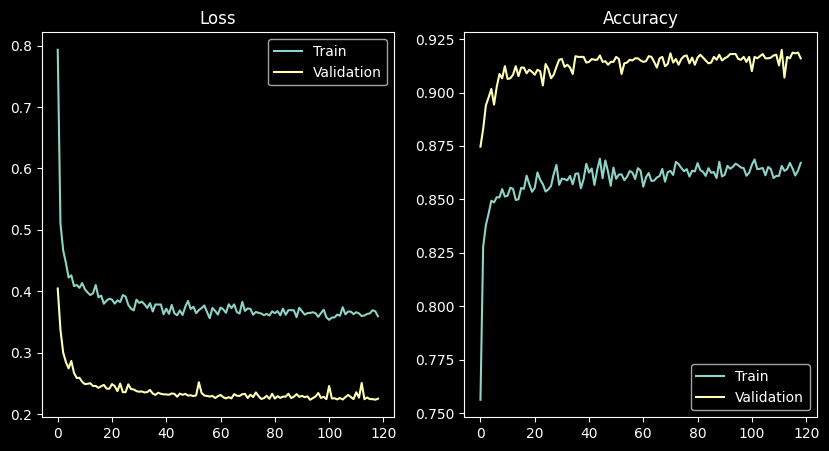

<Figure size 640x480 with 0 Axes>

In [3]:
%matplotlib inline
%run scripts/train_resnet.py

Data Loaded...
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Dataset sizes: {'train': 11034, 'val': 3000, 'test': 3000}

Classification Report -- Train

              precision    recall  f1-score   support

   buildings       0.87      0.91      0.89      1691
      forest       0.98      0.98      0.98      1771
     glacier       0.79      0.86      0.82      1904
    mountain       0.83      0.78      0.81      2012
         sea       0.91      0.90      0.90      1774
      street       0.93      0.87      0.90      1882

    accuracy                           0.88     11034
   macro avg       0.88      0.88      0.88     11034
weighted avg       0.88      0.88      0.88     11034


Classification Report -- Validation

              precision    recall  f1-score   support

   buildings       0.92      0.95      0.93       500
      forest       0.99      0.98      0.98       500
     glacier       0.83      0.87      0.85       500
    mountain      

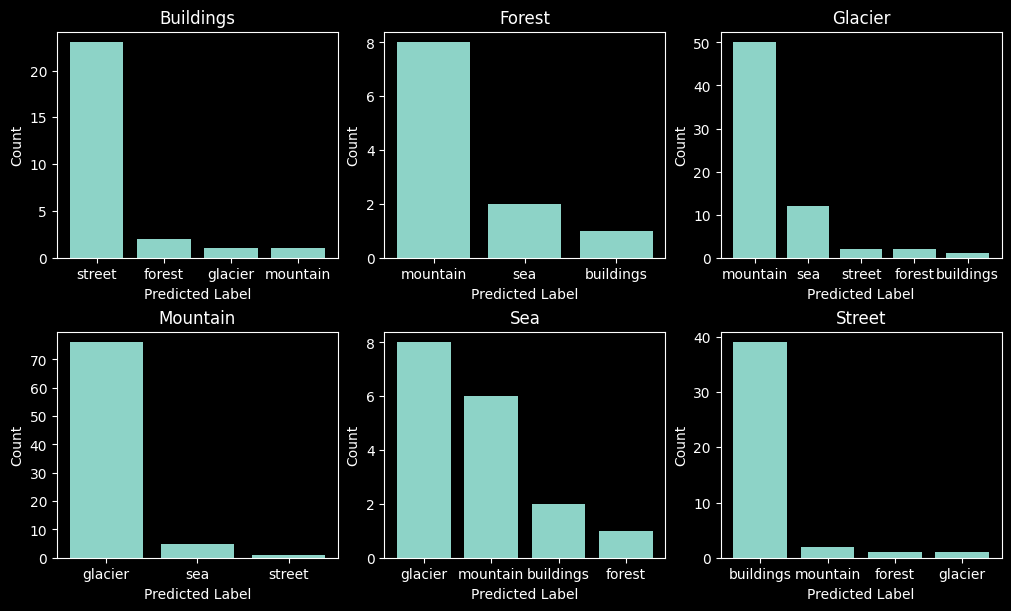

<Figure size 640x480 with 0 Axes>

In [4]:
%matplotlib inline
%run scripts/error_analysis.py

In [5]:
dataloaders, dataset_sizes, class_names = load_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('models/resnet50_20250220_1214.pt', weights_only=False)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
running_corrects = 0
running_loss = 0.0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

test_loss = running_loss / dataset_sizes['test']
test_acc = running_corrects.double() / dataset_sizes['test']

print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.2480 | Test Acc: 0.9117
